# **CSE552 Homework 3**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

* [github.com/Berkin99/MachineLearning](https://github.com/Berkin99/MachineLearning)

## **Part I: Implementing PCA**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [62]:
def pca(X):
    mean = np.mean(X, axis=0)
    
    # Center the data by subtracting the mean
    X_centered = X - mean
    
    # Compute the SVD of the centered data
    # U: Left singular vectors
    # S: Singular values
    # Vh: Right singular vectors (transposed)
    U, S, Vh = np.linalg.svd(X_centered, full_matrices=False)
    
    # The principal components are the right singular vectors 
    # (rows of Vh, so we transpose to get them as columns)
    vectors = Vh.T
    
    # The eigenvalues are the squares of the singular values, divided by (n-1)
    n = X.shape[0]
    weights = (S**2) / (n - 1)
    
    return mean, weights, vectors

Mean: [12.05271115 17.04947007]
Eigenvalues (weights): [40.01495903  3.64888677]
Principal components (vectors): [[ 0.66874442 -0.74349237]
 [ 0.74349237  0.66874442]]


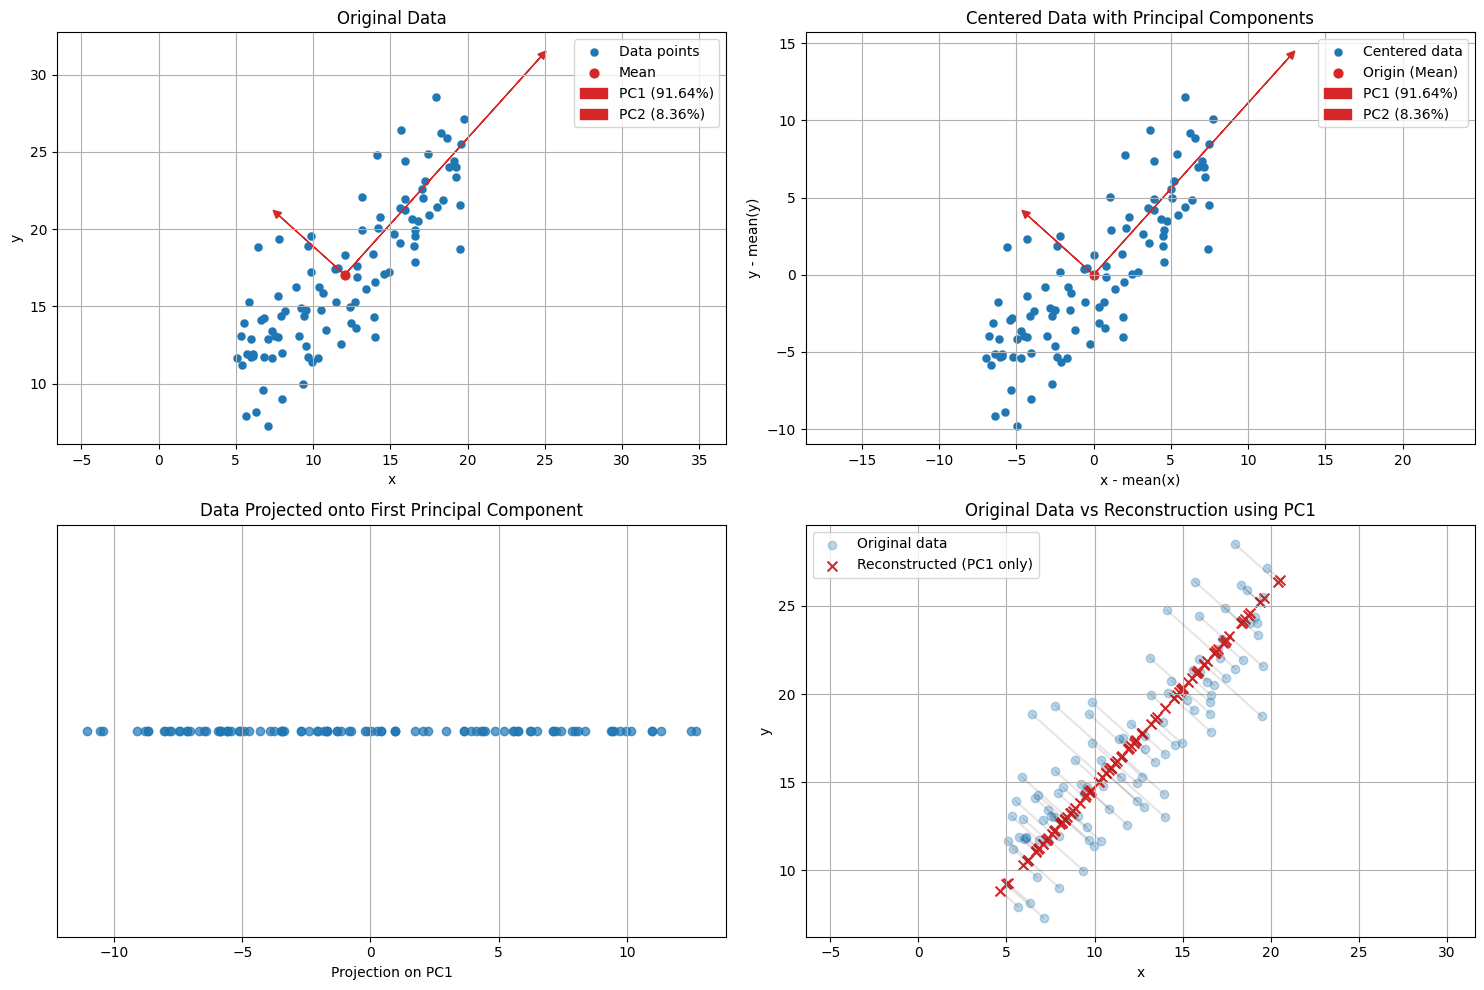

In [47]:
# Create a dataset with positive linear correlation between x and y
np.random.seed(42)  # For reproducibility

x = np.random.uniform(5, 20, 100)
y =  x + np.random.normal(0, 3, 100) + 5
X = np.column_stack((x, y))

# Apply PCA
mean, weights, vectors = pca(X)

# Print the results
print("Mean:", mean)
print("Eigenvalues (weights):", weights)
print("Principal components (vectors):", vectors)

# Calculate the ratio of explained variance
total_var = np.sum(weights)
explained_var_ratio = weights / total_var
# Project the data onto the first principal component
X_centered = X - mean
X_pca_1d = X_centered @ vectors[:, 0:1]  # Project onto first PC

# Reconstruct the data using only the first principal component
X_reconstructed = X_pca_1d @ vectors[:, 0:1].T + mean

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Original Data with Principal Components
plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=1, label='Data points', linewidth=0.1)

# Plot mean point
plt.scatter(mean[0], mean[1], c='C3', s=40, label='Mean')

# Plot principal components as vectors from the mean
for i in range(2):
    # Scale the component by its eigenvalue for visualization
    scale = np.sqrt(weights[i]) * 3
    plt.arrow(
        mean[0], mean[1],
        vectors[0, i] * scale, vectors[1, i] * scale,
        head_width=0.5, head_length=0.5, fc=f'C{3}', ec=f'C{3}', 
        label=f'PC{i+1} ({explained_var_ratio[i]:.2%})',
    )

plt.axis('equal')
plt.grid(True)
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Plot 2: Centered Data with Principal Components
plt.subplot(2, 2, 2)
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=1, label='Centered data', linewidth=0.1)
plt.scatter(0, 0, c='C3', s=40, label='Origin (Mean)')

# Plot principal components from origin
for i in range(2):
    scale = np.sqrt(weights[i]) * 3
    plt.arrow(
        0, 0,
        vectors[0, i] * scale, vectors[1, i] * scale,
        head_width=0.5, head_length=0.5, fc=f'C{3}', ec=f'C{3}', 
        label=f'PC{i+1} ({explained_var_ratio[i]:.2%})',
    )

plt.axis('equal')
plt.grid(True)
plt.title('Centered Data with Principal Components')
plt.xlabel('x - mean(x)')
plt.ylabel('y - mean(y)')
plt.legend()

# Plot 3: Transformed Data along PC1 (1D projection)
plt.subplot(2, 2, 3)
plt.scatter(X_pca_1d, np.zeros_like(X_pca_1d), alpha=0.7)
plt.title('Data Projected onto First Principal Component')
plt.xlabel('Projection on PC1')
plt.yticks([])
plt.grid(True)

# Plot 4: Original Data with Reconstruction
plt.subplot(2, 2, 4)
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label='Original data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='C3', marker='x', s=50, label='Reconstructed (PC1 only)')

# Connect original and reconstructed points with lines
for i in range(len(X)):
    plt.plot(
        [X[i, 0], X_reconstructed[i, 0]], 
        [X[i, 1], X_reconstructed[i, 1]], 
        'k-', alpha=0.1
    )

plt.axis('equal')
plt.grid(True)
plt.title('Original Data vs Reconstruction using PC1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

## **Part II: Using PCA before Classification**

In [63]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.datasets import mnist

In [64]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten 28x28 images to 784-dimensional vectors
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

# Randomly sample 1000 images for PCA visualization
np.random.seed(42)
idx_sample = np.random.choice(x_train.shape[0], 1000, replace=False)
x_sample = x_train_flat[idx_sample]
y_sample = y_train[idx_sample]

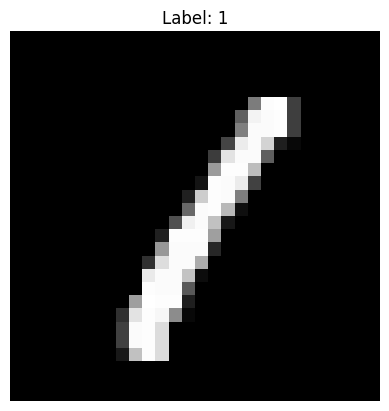

In [65]:
plt.imshow(x_train[3], cmap='gray')
plt.title(f"Label: {y_train[3]}")
plt.axis('off')
plt.show()

In [66]:
mean, eigenvalues, eigenvectors = pca(x_sample)

# Project data to principal components
X_centered = x_sample - mean
X_pca = X_centered @ eigenvectors  # Shape: (1000, 784)

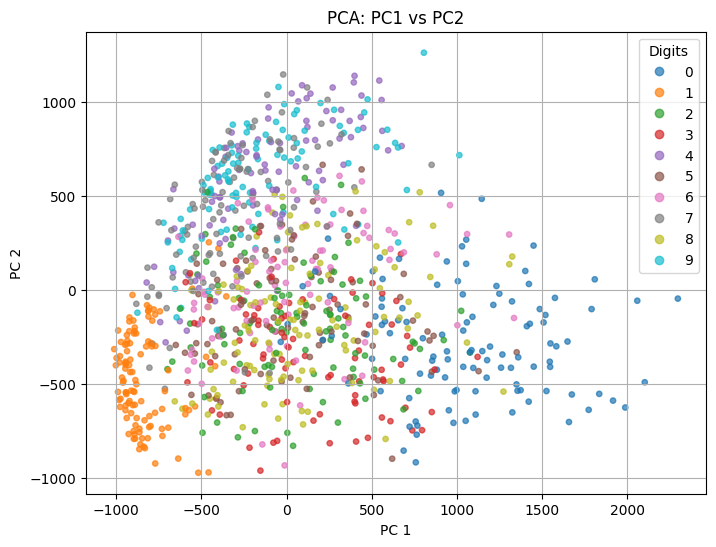

In [67]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', alpha=0.7, s=15)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA: PC1 vs PC2")
plt.grid(True)
plt.show()

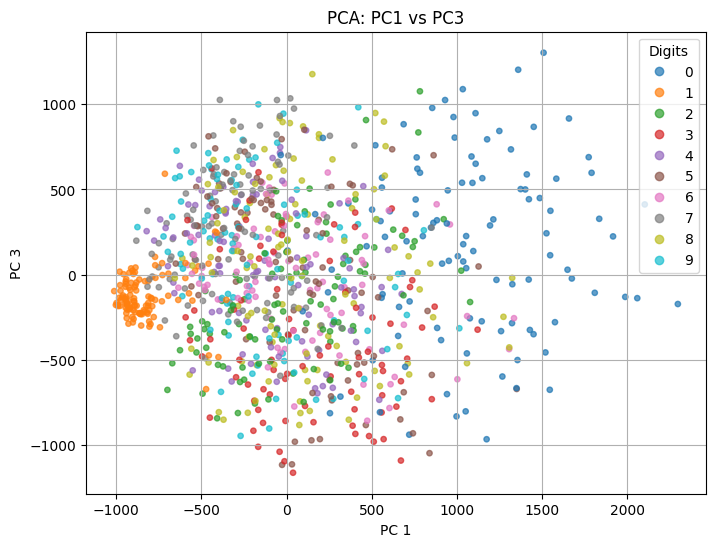

In [68]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 2], c=y_sample, cmap='tab10', alpha=0.7, s=15)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.title("PCA: PC1 vs PC3")
plt.grid(True)
plt.show()


In [69]:
component_counts = [10, 20, 50, 100]
scores_dict = {}

for k in component_counts:
    # Center the full training data
    X_train_centered = x_train_flat - mean
    
    # Project to first k principal components
    X_train_pca_k = X_train_centered @ eigenvectors[:, :k]

    # Start timing
    start_time = time.time()

    # Train Random Forest with cross-validation
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X_train_pca_k, y_train, cv=5)

    # Stop timing
    end_time = time.time()
    elapsed_time = end_time - start_time

    scores_dict[k] = scores
    print(f"Components: {k}, Accuracy: {scores.mean():.4f} ± {scores.std():.4f}, Time: {elapsed_time:.2f} seconds")


Components: 10, Accuracy: 0.9038 ± 0.0050, Time: 113.55 seconds
Components: 20, Accuracy: 0.9448 ± 0.0033, Time: 155.19 seconds
Components: 50, Accuracy: 0.9502 ± 0.0029, Time: 312.52 seconds
Components: 100, Accuracy: 0.9478 ± 0.0032, Time: 443.63 seconds


## **Conclusion**
The classification results demonstrate that applying PCA before training significantly improves both efficiency and model performance on the MNIST dataset. With just
10 principal components, the classifier achieves over 90% accuracy, indicating that a small subset of features captures the majority of the important structure in
the data. Accuracy continues to improve with more components, peaking around 50 components with 95% accuracy, before slightly declining or plateauing. However,
training time increases substantially with each increment in dimensionality, suggesting that 20 to 50 components offer the best trade-off between accuracy and
computational cost. These results confirm that PCA is a powerful preprocessing step that can enhance classification performance while reducing noise and redundancy
in high-dimensional datasets.